# Repairing geographic locations, place names, and extracted data for the NWT Climate Explorer.

## Issue
The location of Inuvik, NWT was found to be incorrect by about ten degrees of longitude. A closer examination of all point locations used by the web tool found that many of the geographic coordinates were in need of refinement and that some place names needed to be updated.

## Fix
A revised spreadsheet of NWT geographic locations was produced (see https://github.com/ua-snap/geospatial-vector-veracity/blob/main/vector_data/point/nwt_point_locations.csv) and used to re-extract downscaled data for each location.

## Validation
This notebook will compare the existing data to the newly extracted data and check for data model integrity and for qualitative similarity.

### Usage note
This notebook switches branches so it should probably be used outside the repo itself. Just `cd` in to the repo.

In [1]:
pwd

'/Users/cparr/workspace/tmp'

In [2]:
cd '../repos/nwt-dash-app/data_prep'

/Users/cparr/workspace/repos/nwt-dash-app/data_prep


In [3]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
from collections import defaultdict
from glob import glob

The previously extracted CSV files (incorrect for Inuvik) are still on branch `master` while the freshly extracted data is on branch `inuvik-rextraction` (forgive the missing 'e'). I want to pull both sets of CSV files and compare them. I'll use the `subprocess` module to checkout the different git branches. This is probably not advisable and should only be used if both branches have clean working trees (no changes, nothing staged, etc.). Using git in the notebook is confusing (but fun!) because it is sensitive to the state of the git repository as it was left in the terminal. Only two branches are relevant here so I can be agnostic regarding which branch this "starts" on. This technique will also hang up if this notebook is being tracked in git because it will see the modifications and yell at you about performing a `checkout`. The recommendation is to use the notebook outside the repo and then chuck it back in when you are ready to commit.

In [4]:
di_branches = defaultdict()
di_branches['master'] = 'inuvik-rextraction'
di_branches['inuvik-rextraction'] = 'master'

def which_branch():
    proc_branch = subprocess.Popen(["git", "branch"], stdout=subprocess.PIPE, universal_newlines=True)
    out_branch = proc_branch.communicate()[0].splitlines()
    current_branch = [x for x in out_branch if x[0] == '*'][0].split(' ')[-1]
    return current_branch

def switch_branch(di_branches):
    checkout = subprocess.Popen(["git", "checkout", di_branches[which_branch()]],
                                stdout=subprocess.PIPE,
                                universal_newlines=True)

In [5]:
which_branch()

'master'

In [6]:
scenarios = ['historical', 'rcp45', 'rcp60', 'rcp85']

di_csv = defaultdict()

def qa_prep():
    di_csv[which_branch()] = {}
    for sc in scenarios:
        di_csv[which_branch()][sc] = {}
        df = pd.read_csv(glob('../data/*' + sc + '*.csv')[0])
        di_csv[which_branch()][sc]['csv'] = df
        di_csv[which_branch()][sc]['shape'] = df.shape
        di_csv[which_branch()][sc]['models'] = sorted(list(df.model.unique()))
        di_csv[which_branch()][sc]['years'] = sorted(list(df.model.unique()))
        di_csv[which_branch()][sc]['place_names'] = sorted(list(df.community.unique()))

qa_prep()

In [7]:
switch_branch(di_branches)

In [8]:
which_branch()

'inuvik-rextraction'

In [9]:
qa_prep()

A dictionary is now populated with the old and new CSV files. Both sets of data are extracted from the same source, so the expectation is that the models and time ranges did not change across extractions. Each scenario is contained within a single CSV file (only 8 CSVs total) so a quick check of the models and years between each scenario pair will suffice.

In [10]:
for sc in scenarios:
    model_check = di_csv['master'][sc]['models'] == di_csv['inuvik-rextraction'][sc]['models']  
    yr_check = di_csv['master'][sc]['years'] == di_csv['inuvik-rextraction'][sc]['years']
    print("Checking %s... Models identical? %s. Years Identical? %s." % (sc, model_check, yr_check))

Checking historical... Models identical? True. Years Identical? True.
Checking rcp45... Models identical? True. Years Identical? True.
Checking rcp60... Models identical? True. Years Identical? True.
Checking rcp85... Models identical? True. Years Identical? True.


However, changes to the place names themselves and the number of extracted locations were made. Specfically, the number of communities was reduced by one in new data extraction because Behchokǫ̀ was previously represented by separate extractions for Behchoko (Rae) and  Behchoko (Edzo). Rae and Edzo were distinct communities, though only located only a few kilometers apart, but are now unified under the name Behchokǫ̀.

The point is that we will have different data shapes and sizes (and obviously different community names) between the two sets of data.

In [11]:
old_places_not_in_new = []
new_places_not_in_old = []

for sc in scenarios:
    
    old_places = di_csv['master'][sc]['place_names']
    new_places = di_csv['inuvik-rextraction'][sc]['place_names']
    old_locs_not_in_new = list(set(old_places) - set(new_places))
    new_locs_not_in_old = list(set(new_places) - set(old_places))

    old_places_not_in_new.append(sorted(old_locs_not_in_new))
    new_places_not_in_old.append(sorted(new_locs_not_in_old))

print("Dropped Location Names")
print(np.unique(old_places_not_in_new))
print('-----------------------------')
print("Added Location Names")
print(np.unique(new_places_not_in_old))

print("Number Old places: %d" % len(old_places))
print("Number New places: %d" % len(new_places))

Dropped Location Names
['Behchoko (Edzo)' 'Behchoko (Rae)' 'Daring Lake Research Stn' 'Detah'
 'Gameti' "Lutselk'e" "N'Dilo" 'Nechalacho' 'Pine Point Mine (Tamerlane)'
 'Trout Lake' 'Wekweeti' 'Whati']
-----------------------------
Added Location Names
['Behchokǫ̀' 'Daring Lake Research Station' 'Dettah' 'Gamètì' 'Ndilǫ'
 'Nechalacho/Thor Lake' 'Pine Point Mine' 'Sambaa K’e' 'Wekweètì' 'Whatì'
 'Łutselkʼe']
Number Old places: 47
Number New places: 46


A reduction in the number of communities by one will reduce the size of each DataFrame by the amount of rows per community for that scenario. We can do quick check on this as well.

In [12]:
for sc in scenarios:
    print(sc)
    old_shape = di_csv['master'][sc]['shape']
    new_shape = di_csv['inuvik-rextraction'][sc]['shape']
    row_delta = old_shape[0] - new_shape[0]
    print("Old CSV Shape:", old_shape)
    print("New CSV Shape:", new_shape)
    print("Old - New Shape Difference (Number Rows):", row_delta)
    rows_per_location = di_csv['master'][sc]['csv'].query("community == 'Inuvik'").shape[0]
    print("Shape Difference Accounted for by reduction of point locations by one:", row_delta == rows_per_location)


historical
Old CSV Shape: (49632, 8)
New CSV Shape: (48576, 8)
Old - New Shape Difference (Number Rows): 1056
Shape Difference Accounted for by reduction of point locations by one: True
rcp45
Old CSV Shape: (75576, 8)
New CSV Shape: (73968, 8)
Old - New Shape Difference (Number Rows): 1608
Shape Difference Accounted for by reduction of point locations by one: True
rcp60
Old CSV Shape: (41736, 8)
New CSV Shape: (40848, 8)
Old - New Shape Difference (Number Rows): 888
Shape Difference Accounted for by reduction of point locations by one: True
rcp85
Old CSV Shape: (64296, 8)
New CSV Shape: (62928, 8)
Old - New Shape Difference (Number Rows): 1368
Shape Difference Accounted for by reduction of point locations by one: True


I am satisfied that the data is essentially intact between the two extractions. The same time ranges, models, and scenarios are all accounted for. The changes in the communities are expected. Now I'll do a brief qualitative examination to look at Inuvik because it was known to be incorrect. Other examinations like this are probably better left to the app itself.

Text(0, 0.5, 'temp (RCP 8.5)')

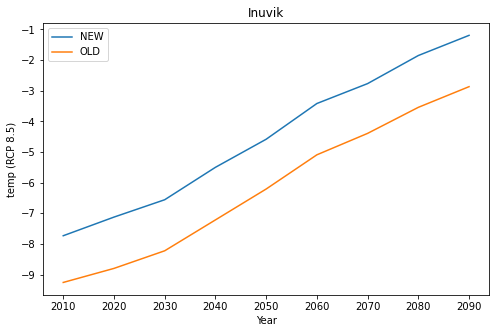

In [13]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")
new_inuvik = di_csv['inuvik-rextraction']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")

plt.plot(new_inuvik[['year', 'tas']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'tas']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Inuvik')
plt.xlabel('Year')
plt.ylabel('temp (RCP 8.5)')

Text(0, 0.5, 'precip (RCP 8.5)')

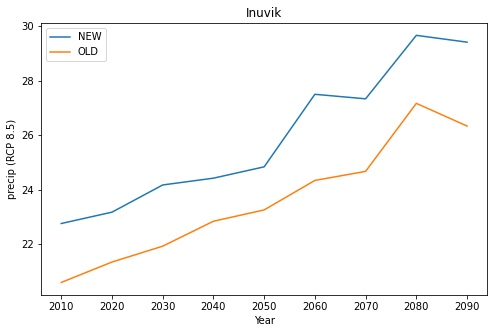

In [14]:
plt.figure(figsize=(8, 5))
old_inuvik = di_csv['master']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")
new_inuvik = di_csv['inuvik-rextraction']['rcp85']['csv'].query("model == '5ModelAvg' and community == 'Inuvik'")

plt.plot(new_inuvik[['year', 'pr']].groupby('year').mean(), label='NEW')
plt.plot(old_inuvik[['year', 'pr']].groupby('year').mean(), label='OLD')    
plt.legend()
plt.title('Inuvik')
plt.xlabel('Year')
plt.ylabel('precip (RCP 8.5)')

Pull request review requested a closer look at ensuring the date ranges are identical between extractions, in particular for the historical dataset. A straight diff shows one begins in 1860 and another in 1850, but that may be an artifiact of melting the DataFrame.

In [15]:
model_yr_mins = []

old_hist = di_csv['master']['historical']['csv']
for model_name in sorted(old_hist.model.unique()):
    yr_min = old_hist.query("model == @model_name").year.min()
    print(model_name, yr_min)
    model_yr_mins.append((model_name, yr_min))

5ModelAvg 1860
GFDL-CM3 1860
GISS-E2-R 1850
IPSL-CM5A-LR 1850
MRI-CGCM3 1850
NCAR-CCSM4 1850


In [16]:
model_yr_mins

[('5ModelAvg', 1860),
 ('GFDL-CM3', 1860),
 ('GISS-E2-R', 1850),
 ('IPSL-CM5A-LR', 1850),
 ('MRI-CGCM3', 1850),
 ('NCAR-CCSM4', 1850)]

In [17]:
new_model_yr_mins = []

new_hist = di_csv['inuvik-rextraction']['historical']['csv']
for model_name in sorted(new_hist.model.unique()):
    yr_min = new_hist.query("model == @model_name").year.min()
    print(model_name, yr_min)
    new_model_yr_mins.append((model_name, yr_min))

new_model_yr_mins

5ModelAvg 1860
GFDL-CM3 1860
GISS-E2-R 1850
IPSL-CM5A-LR 1850
MRI-CGCM3 1850
NCAR-CCSM4 1850


[('5ModelAvg', 1860),
 ('GFDL-CM3', 1860),
 ('GISS-E2-R', 1850),
 ('IPSL-CM5A-LR', 1850),
 ('MRI-CGCM3', 1850),
 ('NCAR-CCSM4', 1850)]

In [18]:
new_model_yr_mins == model_yr_mins

True

OK I am confident that the data span the same ranges - but it is true that comparing across the CSVs or pickles will show differences because changing the community names changed the order in which the data were recomposed after being melted (I think.). Next is to map the new communities to old communities. I can do that!

In [19]:
def get_comm_pickles():
    di_csv[which_branch()]['community_pickle'] = pd.read_pickle('../community_places.pickle')

In [20]:
get_comm_pickles()

In [21]:
switch_branch(di_branches)

In [22]:
get_comm_pickles()

In [23]:
old_pkl = di_csv['master']['community_pickle']

In [24]:
new_pkl = di_csv['inuvik-rextraction']['community_pickle']

In [25]:
new_pkl

,latitude,longitude
Aklavik,68.2200,-135.0087
Behchokǫ̀,62.8335,-116.0514
CanTung Mine,61.9717,-128.2683
Colville Lake,67.0399,-126.0912
ConocoPhillips EL470 Base Camp,65.0534,-127.0355
Daring Lake Research Station,64.5200,-111.3500
Deline,65.1897,-123.4244
Dettah,62.4112,-114.3084
Diavik Mine,64.5114,-110.2897
Ekati Mine,64.6172,-110.1328


In [26]:
behchoko_twice =new_pkl.append(new_pkl.iloc[1])
behchoko_twice

,latitude,longitude
Aklavik,68.2200,-135.0087
Behchokǫ̀,62.8335,-116.0514
CanTung Mine,61.9717,-128.2683
Colville Lake,67.0399,-126.0912
ConocoPhillips EL470 Base Camp,65.0534,-127.0355
Daring Lake Research Station,64.5200,-111.3500
Deline,65.1897,-123.4244
Dettah,62.4112,-114.3084
Diavik Mine,64.5114,-110.2897
Ekati Mine,64.6172,-110.1328


In [27]:
behchoko_twice.sort_index(inplace=True)

In [28]:
old_pkl['updated name'] = behchoko_twice.index.values
old_pkl

,latitude,longitude,updated name
Aklavik,68.22,-135.009,Aklavik
Behchoko (Edzo),62.784,-116.035,Behchokǫ̀
Behchoko (Rae),62.834,-116.051,Behchokǫ̀
CanTung Mine,61.972,-128.268,CanTung Mine
Colville Lake,67.04,-126.091,Colville Lake
ConocoPhillips EL470 Base Camp,65.053,-127.036,ConocoPhillips EL470 Base Camp
Daring Lake Research Stn,64.867,-111.567,Daring Lake Research Station
Deline,65.19,-123.424,Deline
Detah,62.411,-114.308,Dettah
Diavik Mine,64.511,-110.29,Diavik Mine


In [29]:
old_pkl['updated latitude'] = behchoko_twice['latitude'].values
old_pkl['updated longitude'] = behchoko_twice['longitude'].values

In [30]:
old_pkl

,latitude,longitude,updated name,updated latitude,updated longitude
Aklavik,68.22,-135.009,Aklavik,68.2200,-135.0087
Behchoko (Edzo),62.784,-116.035,Behchokǫ̀,62.8335,-116.0514
Behchoko (Rae),62.834,-116.051,Behchokǫ̀,62.8335,-116.0514
CanTung Mine,61.972,-128.268,CanTung Mine,61.9717,-128.2683
Colville Lake,67.04,-126.091,Colville Lake,67.0399,-126.0912
ConocoPhillips EL470 Base Camp,65.053,-127.036,ConocoPhillips EL470 Base Camp,65.0534,-127.0355
Daring Lake Research Stn,64.867,-111.567,Daring Lake Research Station,64.5200,-111.3500
Deline,65.19,-123.424,Deline,65.1897,-123.4244
Detah,62.411,-114.308,Dettah,62.4112,-114.3084
Diavik Mine,64.511,-110.29,Diavik Mine,64.5114,-110.2897


In [ ]:
old_pkl.to_csv('../../../tmp/nwt_location_table_changes.csv')

In [31]:
re_ordered = pd.read_csv('../../../tmp/nwt_location_table_changes2.csv')#, index_col=False)

In [32]:
re_ordered['name'] = re_ordered['Unnamed: 0']
del re_ordered['Unnamed: 0']

In [33]:
re_ordered

,latitude,longitude,updated name,updated latitude,updated longitude,name
0,68.220,-135.009,Aklavik,68.2200,-135.0087,Aklavik
1,62.784,-116.035,Behchokǫ̀,62.8335,-116.0514,Behchoko (Edzo)
2,62.834,-116.051,Behchokǫ̀,62.8335,-116.0514,Behchoko (Rae)
3,61.972,-128.268,CanTung Mine,61.9717,-128.2683,CanTung Mine
4,67.040,-126.091,Colville Lake,67.0399,-126.0912,Colville Lake
5,65.053,-127.036,ConocoPhillips EL470 Base Camp,65.0534,-127.0355,ConocoPhillips EL470 Base Camp
6,64.867,-111.567,Daring Lake Research Station,64.5200,-111.3500,Daring Lake Research Stn
7,65.190,-123.424,Deline,65.1897,-123.4244,Deline
8,62.411,-114.308,Dettah,62.4112,-114.3084,Detah
9,64.511,-110.290,Diavik Mine,64.5114,-110.2897,Diavik Mine


In [34]:
re_ordered[re_ordered['name'] == re_ordered['updated name']]

,latitude,longitude,updated name,updated latitude,updated longitude,name
0,68.220,-135.009,Aklavik,68.2200,-135.0087,Aklavik
3,61.972,-128.268,CanTung Mine,61.9717,-128.2683,CanTung Mine
4,67.040,-126.091,Colville Lake,67.0399,-126.0912,Colville Lake
5,65.053,-127.036,ConocoPhillips EL470 Base Camp,65.0534,-127.0355,ConocoPhillips EL470 Base Camp
7,65.190,-123.424,Deline,65.1897,-123.4244,Deline
9,64.511,-110.290,Diavik Mine,64.5114,-110.2897,Diavik Mine
10,64.617,-110.133,Ekati Mine,64.6172,-110.1328,Ekati Mine
11,60.555,-116.147,Enterprise,60.5555,-116.1472,Enterprise
12,66.257,-128.638,Fort Good Hope,66.2570,-128.6377,Fort Good Hope
13,60.239,-123.475,Fort Liard,60.2392,-123.4752,Fort Liard


In [35]:
re_ordered['updated name'] = np.where(re_ordered['updated name']==re_ordered['name'], '', re_ordered['updated name'])
re_ordered

,latitude,longitude,updated name,updated latitude,updated longitude,name
0,68.220,-135.009,,68.2200,-135.0087,Aklavik
1,62.784,-116.035,Behchokǫ̀,62.8335,-116.0514,Behchoko (Edzo)
2,62.834,-116.051,Behchokǫ̀,62.8335,-116.0514,Behchoko (Rae)
3,61.972,-128.268,,61.9717,-128.2683,CanTung Mine
4,67.040,-126.091,,67.0399,-126.0912,Colville Lake
5,65.053,-127.036,,65.0534,-127.0355,ConocoPhillips EL470 Base Camp
6,64.867,-111.567,Daring Lake Research Station,64.5200,-111.3500,Daring Lake Research Stn
7,65.190,-123.424,,65.1897,-123.4244,Deline
8,62.411,-114.308,Dettah,62.4112,-114.3084,Detah
9,64.511,-110.290,,64.5114,-110.2897,Diavik Mine


In [43]:
old_lats = re_ordered['latitude']
old_lons = re_ordered['longitude']

new_lats = re_ordered['updated latitude']
new_lons = re_ordered['updated longitude']

old_pts = [Point(x, y) for x, y in zip(old_lats, old_lons)]
new_pts = [Point(x, y) for x, y in zip(new_lats, new_lons)]

points_df1 = gpd.GeoDataFrame({'geometry': old_pts}, crs='EPSG:4326')

points_df2 = gpd.GeoDataFrame({'geometry': new_pts}, crs='EPSG:4326')

In [44]:
from geopy.distance import geodesic

In [68]:
geodesic_dist = []
for x, y, x2, y2 in zip(old_lons, old_lats, new_lons, new_lats):
    dist = geodesic((y, x), (y2, x2))
    geodesic_dist.append(round(dist.km, 1))
geodesic_dist

[0.0,
 5.6,
 0.1,
 0.0,
 0.0,
 0.1,
 40.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.1,
 0.0,
 0.0,
 22.5,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 34.8,
 0.0,
 452.3,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.6,
 0.1,
 0.0,
 5.7,
 3.4,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [69]:
re_ordered['distance moved (km)'] = geodesic_dist
re_ordered

,latitude,longitude,updated name,updated latitude,updated longitude,name,distance moved (km)
0,68.220,-135.009,,68.2200,-135.0087,Aklavik,0.0
1,62.784,-116.035,Behchokǫ̀,62.8335,-116.0514,Behchoko (Edzo),5.6
2,62.834,-116.051,Behchokǫ̀,62.8335,-116.0514,Behchoko (Rae),0.1
3,61.972,-128.268,,61.9717,-128.2683,CanTung Mine,0.0
4,67.040,-126.091,,67.0399,-126.0912,Colville Lake,0.0
5,65.053,-127.036,,65.0534,-127.0355,ConocoPhillips EL470 Base Camp,0.1
6,64.867,-111.567,Daring Lake Research Station,64.5200,-111.3500,Daring Lake Research Stn,40.0
7,65.190,-123.424,,65.1897,-123.4244,Deline,0.0
8,62.411,-114.308,Dettah,62.4112,-114.3084,Detah,0.0
9,64.511,-110.290,,64.5114,-110.2897,Diavik Mine,0.0


In [72]:
output = re_ordered[['name', 'updated name', 'latitude', 'updated latitude', 'longitude', 'updated longitude',
                    'distance moved (km)']]
output

,name,updated name,latitude,updated latitude,longitude,updated longitude,distance moved (km)
0,Aklavik,,68.220,68.2200,-135.009,-135.0087,0.0
1,Behchoko (Edzo),Behchokǫ̀,62.784,62.8335,-116.035,-116.0514,5.6
2,Behchoko (Rae),Behchokǫ̀,62.834,62.8335,-116.051,-116.0514,0.1
3,CanTung Mine,,61.972,61.9717,-128.268,-128.2683,0.0
4,Colville Lake,,67.040,67.0399,-126.091,-126.0912,0.0
5,ConocoPhillips EL470 Base Camp,,65.053,65.0534,-127.036,-127.0355,0.1
6,Daring Lake Research Stn,Daring Lake Research Station,64.867,64.5200,-111.567,-111.3500,40.0
7,Deline,,65.190,65.1897,-123.424,-123.4244,0.0
8,Detah,Dettah,62.411,62.4112,-114.308,-114.3084,0.0
9,Diavik Mine,,64.511,64.5114,-110.290,-110.2897,0.0


In [73]:
output.to_csv('nwt_name_location_change_tracker.csv', index=False)